# Set up

In [0]:
import pandas as pd
import numpy as np
import json
import pickle
import os

# Load training data

In [18]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
def datasets():
    train_file = "../data/qanta.train.2018.04.18.json"
    dev_file = "../data/qanta.dev.2018.04.18.json"
    test_file = "../data/qanta.test.2018.04.18.json"

    def load_data(filename):
        data = list()
        with open(filename) as json_data:
            questions = json.load(json_data)["questions"]
        return questions

    train_data = load_data(train_file)
    dev_data = load_data(dev_file)
    test_data = load_data(test_file)

    return train_data, dev_data, test_data

In [0]:
train_data, dev_data, test_data = datasets()

In [0]:
train_df = pd.DataFrame.from_dict(train_data)
dev_df = pd.DataFrame.from_dict(dev_data)
test_df = pd.DataFrame.from_dict(test_data)

In [0]:
# Split up sentences in questions
train_df_new = pd.concat([pd.DataFrame({'text': text, 'answer': row['answer']}, index=[0]) 
           for _, row in train_df.iterrows() 
           for text in sent_tokenize(row['text']) if text != ''])

In [0]:
# Save processed training data
train_df_new.to_pickle("split_train.pkl")

In [0]:
# # Load saved, pre-processed training data
# train_df_saved = pd.read_pickle("split_train.pkl")

In [0]:
# Sample the training data
train_df_new = train_df_saved[:20000]

In [0]:
questions = train_df_new['text'].values.tolist()

In [0]:
answers = train_df_new['answer'].values.tolist()

# Preprocessing

In [0]:
import re

# Source: https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub("[\(\[].*?[\)\]]", "", text) # remove alternate answers inside parenthesis
    text = re.sub(r"[^A-Za-z0-9- ]+", " ", text)
    text = re.sub(r"  ", " ", text)
    text = text.strip()
    
    return text

In [0]:
tidy_questions = []
for q in questions:
    text = clean_text(q)
    tidy_questions.append(text)

In [0]:
questions[:10]

In [0]:
tidy_questions[:10]

In [0]:
tidy_answers = []
for a in answers:
    text = clean_text(a)
    tidy_answers.append(text)

In [0]:
answers[:10]

In [0]:
tidy_answers[:10]

In [0]:
input_texts = tidy_questions
target_texts = []
target_texts_inputs = [] 

for answer in tidy_answers:
  output_sentence = answer + ' <eos>'
  output_sentence_input = '<sos> ' + answer
  target_texts.append(output_sentence)
  target_texts_inputs.append(output_sentence_input)

In [13]:
print(input_texts[172])
print(target_texts[172])
print(target_texts_inputs[172])

paul benacerraf used a story about ernie and johnny to argue that not all identities are meaningful in a paper that aims to show what these objects could not be
numbers <eos>
<sos> numbers


In [0]:
with open('input_text.txt', 'w') as f:
    for item in input_text:
        f.write("%s\n" % item)

In [0]:
with open('target_text.txt', 'w') as f:
    for item in target_text:
        f.write("%s\n" % item)

# Tokenization

In [14]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [15]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequence = input_tokenizer.texts_to_sequences(input_texts)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_sequence)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 43743
Length of longest sentence in input: 103


In [57]:
output_tokenizer = Tokenizer(filters='') # don't remove <> for special tokens
output_tokenizer.fit_on_texts(target_texts + target_texts_inputs)
output_sequence = output_tokenizer.texts_to_sequences(target_texts)
output_sequence_inputs = output_tokenizer.texts_to_sequences(target_texts_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_output_len = max(len(sen) for sen in output_sequence)
print("Length of longest sentence in the output: %g" % max_output_len)

Total unique words in the output: 4853
Length of longest sentence in the output: 38


# Padding

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [18]:
encoder_input_data = pad_sequences(input_sequence, maxlen=max_input_len)
print("encoder_input_data.shape:", encoder_input_data.shape)

encoder_input_data.shape: (20000, 103)


In [19]:
decoder_input_data = pad_sequences(output_sequence, maxlen=max_output_len, padding='post')
print("decoder_input_data.shape:", decoder_input_data.shape)

decoder_input_data.shape: (20000, 38)


# Word Embeddings

In [0]:
from keras.layers import Embedding

embedding_dim = 100
batch_size = 64  # Batch size for training.
num_epochs = 20  # Number of epochs to train for.
hidden_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [21]:
embeddings_index = {}
with open('../reference/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
num_words = len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_input_len, trainable=False)

# One Hot Vectorization

In [0]:
decoder_output_data = np.zeros((
        len(encoder_input_data),
        max_output_len,
        num_words_output
    ),
    dtype='float32'
)

In [25]:
decoder_output_data.shape

(20000, 38, 4854)

In [0]:
for i, d in enumerate(decoder_input_data):
    for t, word in enumerate(d):
        decoder_output_data[i, t, word] = 1

# Build Seq2Seq model

In [0]:
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model

In [28]:
# Define encoder
encoder_inputs = Input(shape=(max_input_len, ), )
encoder_inputs_x = embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(hidden_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_inputs_x)
encoder_states = [state_h, state_c]

In [0]:
# Define decoder
decoder_inputs = Input(shape=(max_output_len, ), )
decoder_embedding = Embedding(num_words_output, hidden_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs)
decoder_LSTM = LSTM(hidden_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_inputs_x, initial_state=encoder_states)

In [0]:
# Define dense layer
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [31]:
# Build and compile model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 103)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 103, 100)     4374400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 256)      1242624     input_2[0][0]                    
____________________________________________________________________________________________

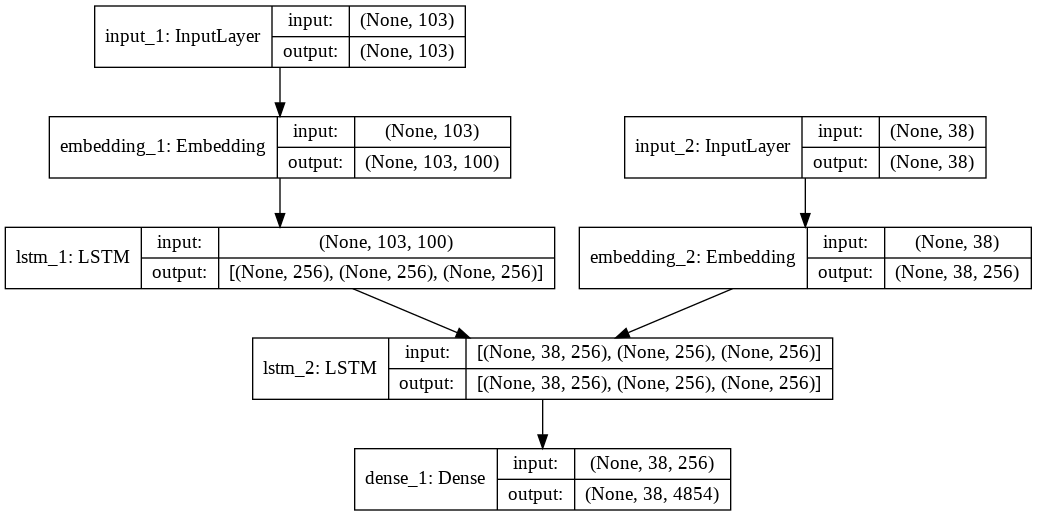

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='seq2seq_final.png', show_shapes=True, show_layer_names=True)

# Train model

In [34]:
history = model.fit([encoder_input_data, decoder_input_data], 
                     decoder_output_data, 
                     epochs=num_epochs, 
                     batch_size=batch_size,
                     validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 130s 8ms/step - loss: 0.9133 - acc: 0.9203 - val_loss: 0.5626 - val_acc: 0.9377
Epoch 2/20
16000/16000 [==============================] - 127s 8ms/step - loss: 0.4797 - acc: 0.9385 - val_loss: 0.5254 - val_acc: 0.9399
Epoch 3/20
16000/16000 [==============================] - 127s 8ms/step - loss: 0.4201 - acc: 0.9414 - val_loss: 0.5123 - val_acc: 0.9432
Epoch 4/20
16000/16000 [==============================] - 128s 8ms/step - loss: 0.3547 - acc: 0.9460 - val_loss: 0.5098 - val_acc: 0.9468
Epoch 5/20
16000/16000 [==============================] - 127s 8ms/step - loss: 0.2867 - acc: 0.9543 - val_loss: 0.5055 - val_acc: 0.9511
Epoch 6/20
16000/16000 [==============================] - 127s 8ms/step - loss: 0.2204 - acc: 0.9657 - val_loss: 0.4990 - val_acc: 0.9556
Epoch 7/20
16000/16000 [===

# Visualize learning history

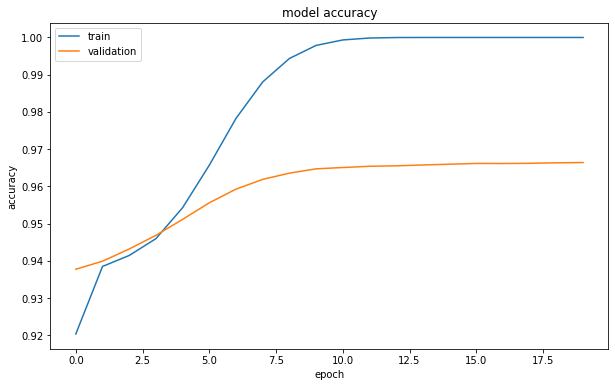

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

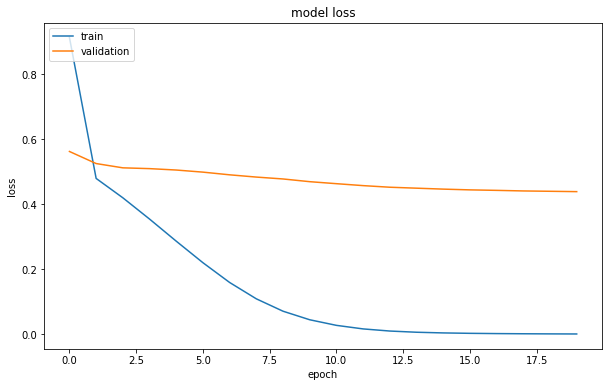

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Save model

In [0]:
# Save model
model.save("seq2seq_final.h5")

# Inference models

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

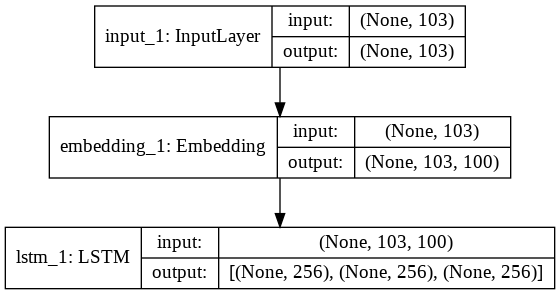

In [45]:
# Plot encoder model
plot_model(encoder_model, to_file='encoder_final.png', show_shapes=True, show_layer_names=True)

In [0]:
decoder_state_input_h = Input(shape=(hidden_dim, ),)
decoder_state_input_c = Input(shape=(hidden_dim, ), )
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_LSTM(decoder_inputs_single_x, initial_state=decoder_state_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_state_inputs,
    [decoder_outputs] + decoder_states
)

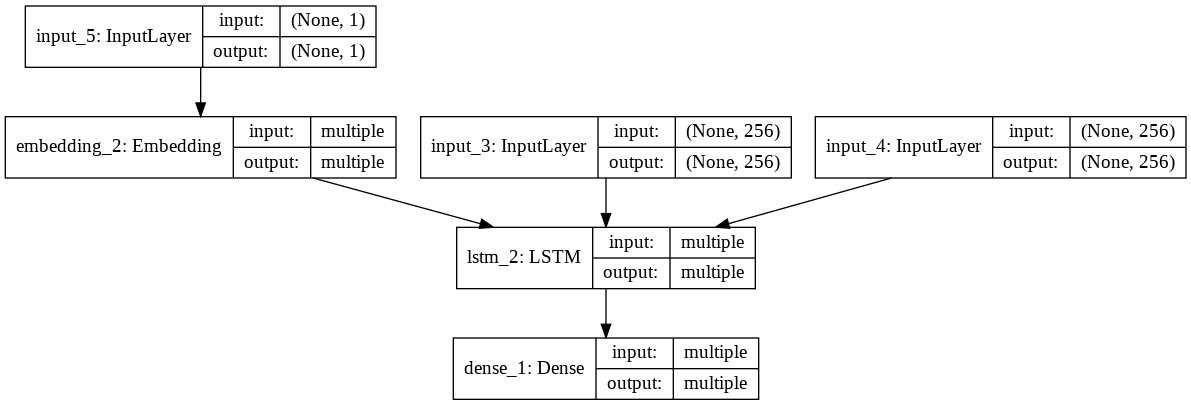

In [41]:
# Plot prediction model
plot_model(decoder_model, to_file='decoder_final.png', show_shapes=True, show_layer_names=True)

# Making Predictions

In [0]:
# Source: https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/

def make_guess(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    idx = np.argmax(output_tokens[0, -1, :])

    if idx > 0:
        word = idx2word_target[idx]
        output_sentence.append(word)

    target_seq[0, 0] = idx
    states_value = [h, c]

    return ' '.join(output_sentence)

In [0]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [172]:
i = np.random.choice(len(input_texts))
input_seq = encoder_input_data[i:i+1]
guess = make_guess(input_seq)
print('Question:', input_texts[i])
print('Answer:', target_texts[i])
print('Guess:', guess)

Question: its minor characters include the adulterous dr nastini as well as captain gnorostiaga whose police report detailing a servant s murder of her boyfriend pancho in her mistress bed takes up much of the twelfth episode
Answer: heartbreak tango or boquitas pintadas <eos>
Guess: enchiridion
